In [5]:
from pandas import Series

# Corrected function for train-test split
def series_train_test_split(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    trn_size: int = int(len(data) * trn_pct)
    train: Series = data.iloc[:trn_size]  # One-dimensional indexing
    test: Series = data.iloc[trn_size:]
    return train, test


In [6]:
from sklearn.base import RegressorMixin

# Define PersistenceOptimistRegressor
class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0

    def fit(self, X: Series):
        self.last = X.iloc[-1]  # Store the last observed value
        return

    def predict(self, X: Series) -> Series:
        prd: list = X.shift().values.ravel()  # Shift predictions
        prd[0] = self.last  # Set the first prediction to the last observed value
        prd_series: Series = Series(prd, index=X.index)
        return prd_series


In [7]:
# Define PersistenceRealistRegressor
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]

    def fit(self, X: Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])  # Use the last observed value for each step
        self.last = X.iloc[-1]  # Store the last observed value
        prd_series: Series = Series(self.estimations, index=X.index)
        return prd_series

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.last]  # Predict the last observed value for the entire series
        prd_series: Series = Series(prd, index=X.index)
        return prd_series


In [8]:
from pandas import read_csv, DataFrame, Series

# File details
filename: str = "/Users/pascalludwig/Documents/Master/Semester 1/Term 2/Data Science/Project/DataScience/Projeto/TimeSeries/forecast_ny_arrests.csv"
file_tag: str = "NY_Arrests"
target: str = "Manhattan"
timecol: str = "Date"

# Load the dataset
data: DataFrame = read_csv(
    filename,
    sep=";",  # Semicolon-separated values
    decimal=".",  # Use period for decimal
    parse_dates=[timecol],  # Parse the Date column
    infer_datetime_format=True,
)
data.set_index(timecol, inplace=True)

# Extract the target series
series: Series = data[target]

# Perform train-test split
train, test = series_train_test_split(series, trn_pct=0.90)

# Check sizes of train and test sets
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 5259, Test size: 585


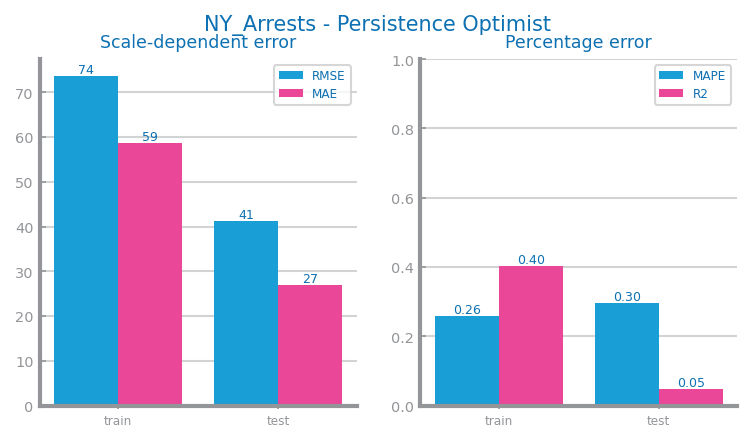

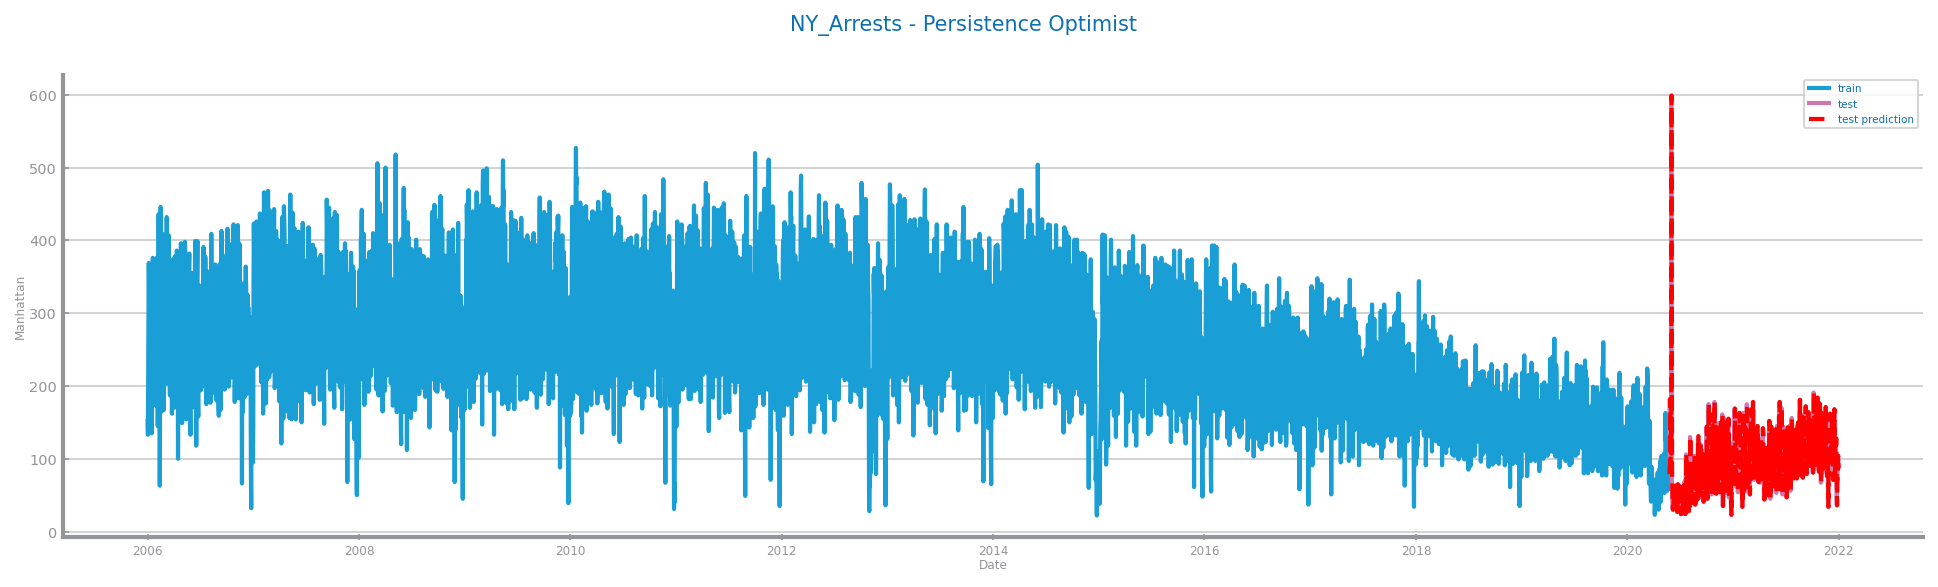

In [9]:
from dslabs_functions import plot_forecasting_eval, plot_forecasting_series
from matplotlib.pyplot import savefig

# Train PersistenceOptimistRegressor
fr_mod_optimist = PersistenceOptimistRegressor()
fr_mod_optimist.fit(train)

# Generate predictions
prd_trn_optimist: Series = fr_mod_optimist.predict(train)
prd_tst_optimist: Series = fr_mod_optimist.predict(test)

# Evaluate the forecast
plot_forecasting_eval(train, test, prd_trn_optimist, prd_tst_optimist, title=f"{file_tag} - Persistence Optimist")
savefig(f"images/{file_tag}_persistence_optim_eval.png")

# Visualize the forecast
plot_forecasting_series(
    train,
    test,
    prd_tst_optimist,
    title=f"{file_tag} - Persistence Optimist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_persistence_optim_forecast.png")


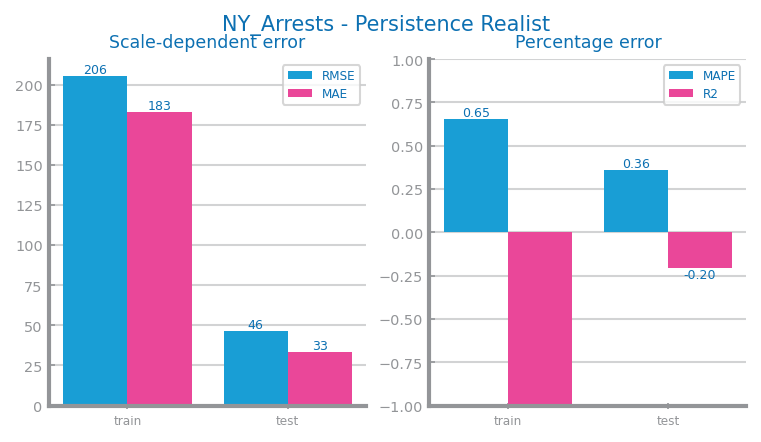

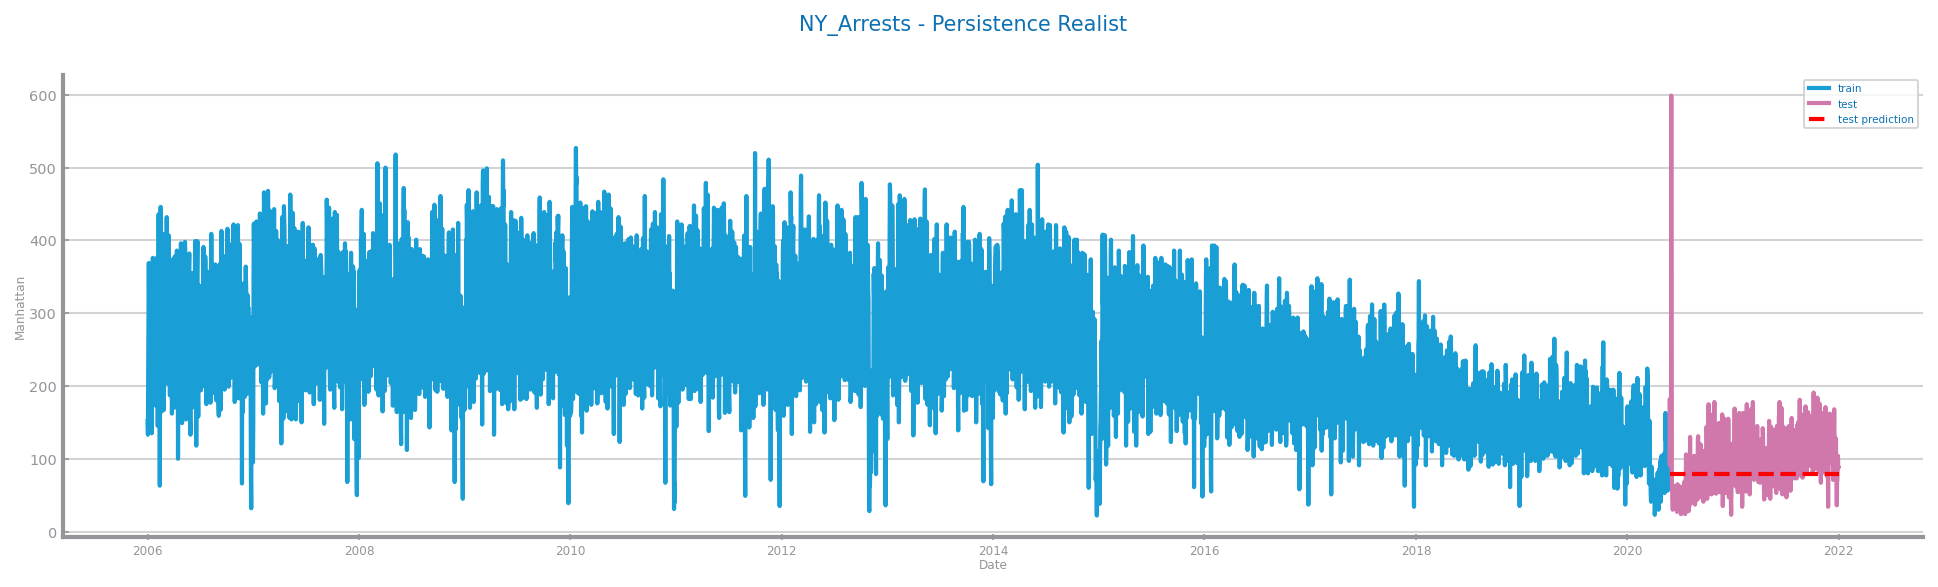

In [10]:
# Train PersistenceRealistRegressor
fr_mod_realist = PersistenceRealistRegressor()
fr_mod_realist.fit(train)

# Generate predictions
prd_trn_realist: Series = fr_mod_realist.predict(train)
prd_tst_realist: Series = fr_mod_realist.predict(test)

# Evaluate the forecast
plot_forecasting_eval(train, test, prd_trn_realist, prd_tst_realist, title=f"{file_tag} - Persistence Realist")
savefig(f"images/{file_tag}_persistence_real_eval.png")

# Visualize the forecast
plot_forecasting_series(
    train,
    test,
    prd_tst_realist,
    title=f"{file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_persistence_real_forecast.png")
